# **Question 1: Do companies with lower debt ratios (≤ 33%) outperform highly leveraged companies in terms of long-term returns ?**

The SPX Dataset Copy.xlsx file was compiled from Bloomberg Terminal data using the Excel Add-In, ensuring accuracy and consistency across all financial metrics. It contains firm-level data for S&P 500 companies, including long-term debt-to-equity ratios, stock price history, volatility, cash ratios, and Bloomberg ESG scores. The dataset spans 2015–2019, allowing for a multi-year perspective on corporate leverage and sustainability performance. After retrieval, the data was cleaned, validated, and structured into a final Excel file that served as the foundation for all quantitative analysis in this study.

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from pathlib import Path

DATA_BLOOM = "SPX Dataset Copy.xlsx"
COMP_INFO = 0
LOW_DEBT_THRESHOLD = 0.33         # D/E <= 0.33 => "Low leverage"
HIGH_DEBT_TOP_PCT = 0.30          # Top 30% by D/E => "High leverage"
ANNUALIZATION_YEARS = 9           # 2015 -> 2024 (end-start) = 9 compounding years

OUT_DIR = Path("outputs_rq1") #rq1 stands for research question 1
OUT_DIR.mkdir(parents=True, exist_ok=True)
SUMMARY_CSV = OUT_DIR / "rq1_group_summary.csv"
FULL_DATA_CSV = OUT_DIR / "rq1_full_with_groups.csv"
FIG_BOX = OUT_DIR / "rq1_boxplot_returns.png"
FIG_BAR = OUT_DIR / "rq1_bar_means_ci.png"

Pandas was imported to load and organize the stock dataset, handle missing values, and perform calculations like returns and ratios, while NumPy is needed to perform numerical operations and array-based computations. SciPy provides statistical tools for analyzing relationships between variables, such as correlations between ESG scores and financial ratios. Matplotlib was used to create visualizations like line and scatter plots to illustrate trends in the data, and Pathlib helped manage file paths and ensure smooth access to datasets across different systems.

In [ ]:
!pip install yfinance --quiet
import yfinance as yf



First, the code defines key thresholds and constants such as the debt-to-equity (D/E) ratio cutoff for low leverage (≤0.33), the top 30% D/E range for high leverage, and the nine-year period between 2015 and 2024, which establish how companies are grouped and how long-term returns will be measured. Next, a dedicated output directory is created to store all results in an organized way, ensuring that each file (summary tables, full labeled data, and plots) is automatically saved in one place. Last, specific file paths are defined for each output, allowing the program to export cleaned datasets, statistical summaries, and visualizations that compare the performance of low- versus high-leverage companies.

In [ ]:
#This section prepares the data for the first question


df = pd.read_excel(DATA_BLOOM, sheet_name=COMP_INFO)
#This line sets the data frame as the pandas-read information from our bloomberg data

# This line takes out the spaces that are unncessary or extra
df.columns = [str(c).strip() for c in df.columns]

required_cols = ["Ticker", "Name", "Price 2015", "Price 2024", "2015-2019 AVG D/E RATIO"]
missing_cols = [c for c in required_cols if c not in df.columns]
if missing_cols:
    raise ValueError(f"Missing required columns: {missing_cols}\nFound: {list(df.columns)}")
    # This only takes the required columns from the dataset that pertain to the question at hand
    # The following lines establish that if there is a missing column, it will raise an error
    # The column will be added to the missing columns list and show its name

# Keep only needed columns (and copy) for reference to original data
df = df[required_cols].copy()

# Rename for convenience
df = df.rename(columns={
    "Price 2015": "price_2015",
    "Price 2024": "price_2024",
    "2015-2019 AVG D/E RATIO": "de_avg_1519"})

# Drop rows with missing key fields in the subset of necessary columns, and make a copy of the data again
df = df.dropna(subset=["price_2015", "price_2024", "de_avg_1519"]).copy()

# Remove non-positive or pathological prices (avoid divide-by-zero, etc.)
df = df[(df["price_2015"] > 0) & (df["price_2024"] > 0)].copy()


#This shows the dataframe after the cleaning functions
print(f"Rows after cleaning: {len(df)}")
df.head()

Rows after cleaning: 437


,Ticker,Name,price_2015,price_2024,de_avg_1519
0,A UN Equity,Agilent Technologies Inc,41.810,134.34,0.432350
1,AAPL UW Equity,Apple Inc,26.315,250.42,0.868615
2,ABBV UN Equity,AbbVie Inc,59.240,177.70,7.768815
4,ABT UN Equity,Abbott Laboratories,44.910,113.11,0.725853
5,ACGL UW Equity,Arch Capital Group Ltd,23.250,92.35,0.223046


In [ ]:

# Total return over the window
df["total_return_2015_2024"] = (df["price_2024"] / df["price_2015"]) - 1.0

# This formula converts total growth into an annualized (compounded) return by raising the total return ratio
# to the power of one divided by the number of years, showing the stock’s average yearly growth rate.
df["ann_return_2015_2024"] = (df["price_2024"] / df["price_2015"])**(1/ANNUALIZATION_YEARS) - 1.0

# This line creates a new version of the debt-to-equity ratio column where extreme outliers are capped between 0
# and the 99th percentile, preventing unusually high values from distorting visualizations or analyses.
df["de_avg_1519_clipped"] = df["de_avg_1519"].clip(lower=0, upper=df["de_avg_1519"].quantile(0.99))

df[["Ticker", "de_avg_1519", "total_return_2015_2024", "ann_return_2015_2024"]].head()

,Ticker,de_avg_1519,total_return_2015_2024,ann_return_2015_2024
0,A UN Equity,0.432350,2.213107,0.138479
1,AAPL UW Equity,0.868615,8.516245,0.284454
2,ABBV UN Equity,7.768815,1.999662,0.129817
4,ABT UN Equity,0.725853,1.518593,0.108085
5,ACGL UW Equity,0.223046,2.972043,0.165620


So, thus far, we've cleaned the data and created formulas and columns for the returns over the allotted time period.

In [ ]:
# Here, we create a group for a low debt threshold, which is previously designated as below 0.33
# If the condition is true, assign a 1, if false, assign a 0
df["group_low"] = np.where(df["de_avg_1519"] <= LOW_DEBT_THRESHOLD, 1, 0)

# High debt group by top X% threshold
high_cut = df["de_avg_1519"].quantile(1 - HIGH_DEBT_TOP_PCT)  # e.g., 70th percentile for top 30%
df["group_high"] = np.where(df["de_avg_1519"] >= high_cut, 1, 0)

# Merge into a single categorical label: Low / Middle / High
def label_group(row):
    if row["group_low"] == 1:
        return "Low (≤ 0.33)"
    elif row["group_high"] == 1:
        return f"High (Top {int(HIGH_DEBT_TOP_PCT*100)}%)"
    else:
        return "Middle"

df["leverage_group"] = df.apply(label_group, axis=1)
# the formulas are applied to each row

# Save full dataset with groups
df.to_csv(FULL_DATA_CSV, index=False)
print(f"High-debt cutoff (quantile): {high_cut:.4f}")
df["leverage_group"].value_counts()


High-debt cutoff (quantile): 1.2076


,count
leverage_group,
Middle,232
High (Top 30%),131
Low (≤ 0.33),74


This upcoming cell defines a utility that computes a group’s mean and the 95% confidence-interval half-width using the t-distribution, then groups the cleaned dataset by the leverage_group categories (Low/Middle/High). For each group it calculates descriptive statistics for both total and annualized returns and uses the helper to attach an uncertainty measure (CI half-width) for the annualized mean. Finally, it assembles those metrics into a tidy summary table, sorts it by group, saves it to disk for reproducibility, and displays it for inspection.

In [ ]:
def ci_mean(x, alpha=0.05):
    x = pd.Series(x).dropna()
    n = len(x)
    if n < 2:
        return (x.mean(), np.nan)
    mean = x.mean()
    sd = x.std(ddof=1)
    se = sd / np.sqrt(n)
    tcrit = stats.t.ppf(1 - alpha/2, df=n-1)
    halfwidth = tcrit * se
    return mean, halfwidth

#this function makes a new definition to calculate the ci half width and the mean

#The groupby function is used here to group the aggregate functions by each leverage group category
grouped = []
for g, sub in df.groupby("leverage_group"):
    n = len(sub)
    mean_tr = sub["total_return_2015_2024"].mean()
    med_tr  = sub["total_return_2015_2024"].median()
    std_tr  = sub["total_return_2015_2024"].std(ddof=1)

    mean_ar = sub["ann_return_2015_2024"].mean()
    med_ar  = sub["ann_return_2015_2024"].median()
    std_ar  = sub["ann_return_2015_2024"].std(ddof=1)
    mean_ar_ci, half = ci_mean(sub["ann_return_2015_2024"])
    grouped.append({
        "leverage_group": g,
        "n": n,
        "total_return_mean": mean_tr,
        "total_return_median": med_tr,
        "total_return_std": std_tr,
        "ann_return_mean": mean_ar,
        "ann_return_median": med_ar,
        "ann_return_std": std_ar,
        "ann_return_CI95_halfwidth": half})

summary_df = pd.DataFrame(grouped).sort_values("leverage_group")
summary_df.to_csv(SUMMARY_CSV, index=False)
summary_df


,leverage_group,n,total_return_mean,total_return_median,total_return_std,ann_return_mean,ann_return_median,ann_return_std,ann_return_CI95_halfwidth
0,High (Top 30%),131,2.535228,1.145316,4.876206,0.106847,0.088510,0.100220,0.017323
1,Low (≤ 0.33),74,6.178980,2.009678,19.357717,0.158761,0.130235,0.127267,0.029485
2,Middle,232,1.925660,1.181923,2.457169,0.095160,0.090558,0.093573,0.012104


In [ ]:
# Hypothesis Test: Low vs High (Welch t-test)

low = df.loc[df["leverage_group"].str.startswith("Low"), "ann_return_2015_2024"].dropna()
high = df.loc[df["leverage_group"].str.startswith("High"), "ann_return_2015_2024"].dropna()

#These lines of code filters the data into high and low leverage groups, and drops any missing values

tstat, pval = stats.ttest_ind(low, high, equal_var=False)  # Welch test (unequal variances)

# Effect size (Cohen's d using pooled SD with unequal sizes)
# While the t-test tells us whether the difference between groups is statistically significant, Cohen’s d shows
# how large and meaningful that difference is in practical terms. This helps distinguish between effects that
# are statistically detectable due to a large sample size and effects that are economically meaningful and relevant
# for real-world decision making.

def cohens_d(a, b):
    a, b = pd.Series(a).dropna(), pd.Series(b).dropna()
    na, nb = len(a), len(b)
    sa2, sb2 = a.var(ddof=1), b.var(ddof=1)
    # Pooled SD (unbiased)
    sp2 = ((na-1)*sa2 + (nb-1)*sb2) / (na+nb-2) if (na+nb-2) > 0 else np.nan
    if sp2 <= 0 or np.isnan(sp2):
        return np.nan
    d = (a.mean() - b.mean()) / np.sqrt(sp2)
    return d

d_effect = cohens_d(low, high)

# Print the number of observations, mean, and standard deviation for the Low-leverage group
# Print the number of observations, mean, and standard deviation for the High-leverage group
# Print the t-test results: t-statistic (strength of difference) and p-value (statistical significance)
# Print the effect size result (Cohen's d), which shows how large the difference is in standardized terms
# Reference values: 0.2 = small, 0.5 = medium, 0.8 = large effect size

print("=== Welch t-test: Low vs High (annualized returns) ===")
print(f"Low group N = {len(low)} | mean = {low.mean():.4%} | std = {low.std(ddof=1):.4%}")
print(f"High group N = {len(high)} | mean = {high.mean():.4%} | std = {high.std(ddof=1):.4%}")
print(f"t-statistic = {tstat:.4f},  p-value = {pval:.6f}")
print(f"Cohen's d   = {d_effect:.3f}  (|0.2| small, |0.5| medium, |0.8| large)")


=== Welch t-test: Low vs High (annualized returns) ===
Low group N = 74 | mean = 15.8761% | std = 12.7267%
High group N = 131 | mean = 10.6847% | std = 10.0220%
t-statistic = 3.0197,  p-value = 0.003071
Cohen's d   = 0.469  (|0.2| small, |0.5| medium, |0.8| large)


/tmp/ipython-input-2257180556.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=order, showmeans=True)


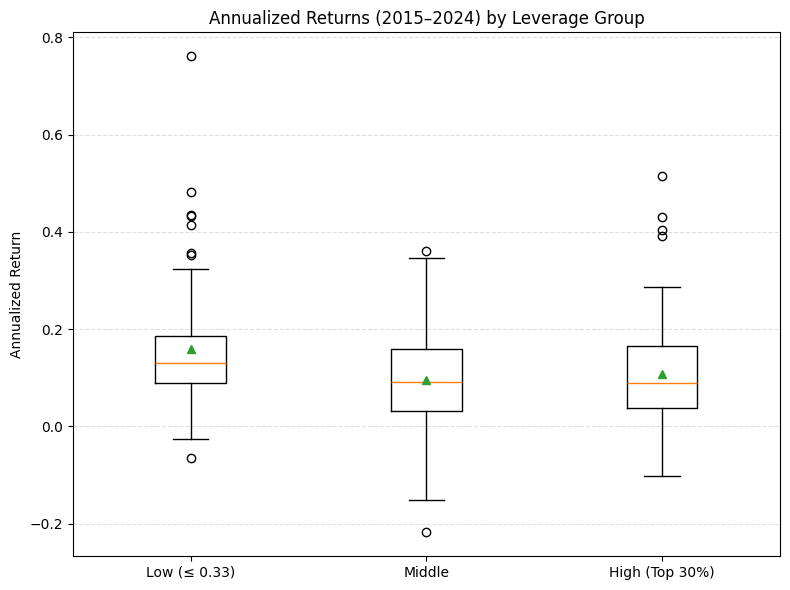

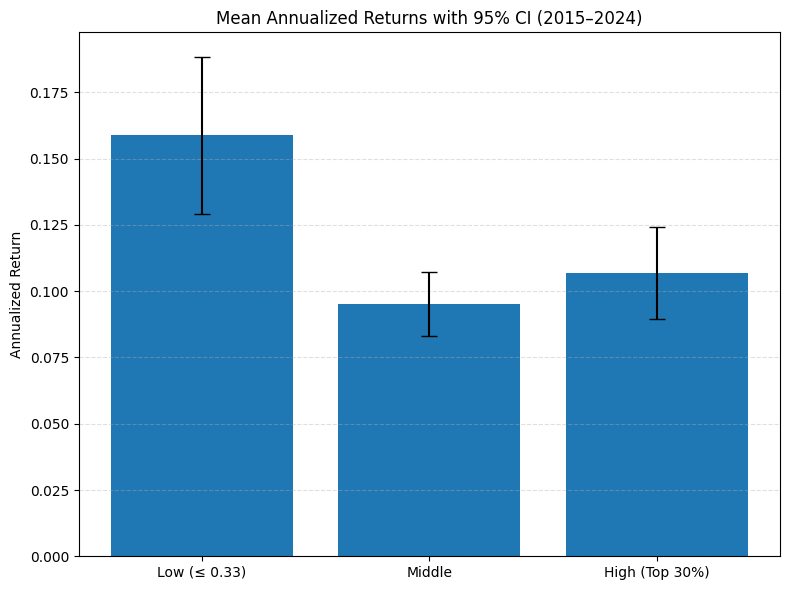

In [ ]:

# Visualization

plt.figure(figsize=(8,6))
# Boxplot of annualized returns by group
order = ["Low (≤ 0.33)", "Middle", f"High (Top {int(HIGH_DEBT_TOP_PCT*100)}%)"]
data = [df.loc[df["leverage_group"] == g, "ann_return_2015_2024"].dropna() for g in order]
plt.boxplot(data, labels=order, showmeans=True)
plt.title("Annualized Returns (2015–2024) by Leverage Group")
plt.ylabel("Annualized Return")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.savefig(FIG_BOX, dpi=200)
plt.show()

#The showmeans= True commands the program to show the mean in the boxplot
# The last three lines adjust layout and save the figure as an image file


# Bar chart of group means with 95% CI error bars
plt.figure(figsize=(8,6))
means, errs = [], []
for g in order:
    sub = df.loc[df["leverage_group"] == g, "ann_return_2015_2024"].dropna()
    m, hw = ci_mean(sub, alpha=0.05)
    means.append(m)
    errs.append(hw)

x = np.arange(len(order))
plt.bar(x, means, yerr=errs, capsize=6)
plt.xticks(x, order)
plt.title("Mean Annualized Returns with 95% CI (2015–2024)")
plt.ylabel("Annualized Return")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.savefig(FIG_BAR, dpi=200)
plt.show()



In [ ]:
sp500 = yf.download("^GSPC", start="2015-01-01", end="2024-12-31")

/tmp/ipython-input-2150991973.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download("^GSPC", start="2015-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed


In [ ]:
sp500.columns

MultiIndex([( 'Close', '^GSPC'),
            (  'High', '^GSPC'),
            (   'Low', '^GSPC'),
            (  'Open', '^GSPC'),
            ('Volume', '^GSPC')],
           names=['Price', 'Ticker'])

In [ ]:
sp_total_return = (sp500[("Close", "^GSPC")].iloc[-1] / sp500[("Close", "^GSPC")].iloc[0]) - 1
sp_ann_return = (sp500[("Close", "^GSPC")].iloc[-1] / sp500[("Close", "^GSPC")].iloc[0]) ** (1/9) - 1

print(f"S&P 500 Total Return (2015–2024): {sp_total_return:.2%}")
print(f"S&P 500 Annualized Return (2015–2024): {sp_ann_return:.2%}")

S&P 500 Total Return (2015–2024): 187.00%
S&P 500 Annualized Return (2015–2024): 12.43%


In [ ]:
sp500.columns = sp500.columns.droplevel(1)
sp500.head()

Price,Close,High,Low,Open,Volume
Date,,,,,
2015-01-02,2058.199951,2072.360107,2046.040039,2058.899902,2708700000
2015-01-05,2020.579956,2054.439941,2017.339966,2054.439941,3799120000
2015-01-06,2002.609985,2030.250000,1992.439941,2022.150024,4460110000
2015-01-07,2025.900024,2029.609985,2005.550049,2005.550049,3805480000
2015-01-08,2062.139893,2064.080078,2030.609985,2030.609985,3934010000


In [ ]:
sp_total_return = (sp500["Close"].iloc[-1] / sp500["Close"].iloc[0]) - 1
sp_ann_return = (sp500["Close"].iloc[-1] / sp500["Close"].iloc[0]) ** (1/9) - 1

In [ ]:
print(f"S&P 500 Total Return (2015–2024): {sp_total_return:.2%}")
print(f"S&P 500 Annualized Return (2015–2024): {sp_ann_return:.2%}")

S&P 500 Total Return (2015–2024): 187.00%
S&P 500 Annualized Return (2015–2024): 12.43%


In [ ]:
summary_df = pd.DataFrame(grouped).sort_values("leverage_group")
summary_df.to_csv(SUMMARY_CSV, index=False)
summary_df

,leverage_group,n,total_return_mean,total_return_median,total_return_std,ann_return_mean,ann_return_median,ann_return_std,ann_return_CI95_halfwidth
0,High (Top 30%),131,2.535228,1.145316,4.876206,0.106847,0.088510,0.100220,0.017323
1,Low (≤ 0.33),74,6.178980,2.009678,19.357717,0.158761,0.130235,0.127267,0.029485
2,Middle,232,1.925660,1.181923,2.457169,0.095160,0.090558,0.093573,0.012104


In [ ]:
print("=== Comparison to S&P 500 Benchmark ===")
print(f"S&P 500 Annualized Return (2015–2024): {sp_ann_return:.2%}\n")

# Print each group's average annualized return as a percentage
for _, row in summary_df[["leverage_group", "ann_return_mean"]].iterrows():
    print(f"{row['leverage_group']:<15} | {row['ann_return_mean']:.2%}")

=== Comparison to S&P 500 Benchmark ===
S&P 500 Annualized Return (2015–2024): 12.43%

High (Top 30%)  | 10.68%
Low (≤ 0.33)    | 15.88%
Middle          | 9.52%


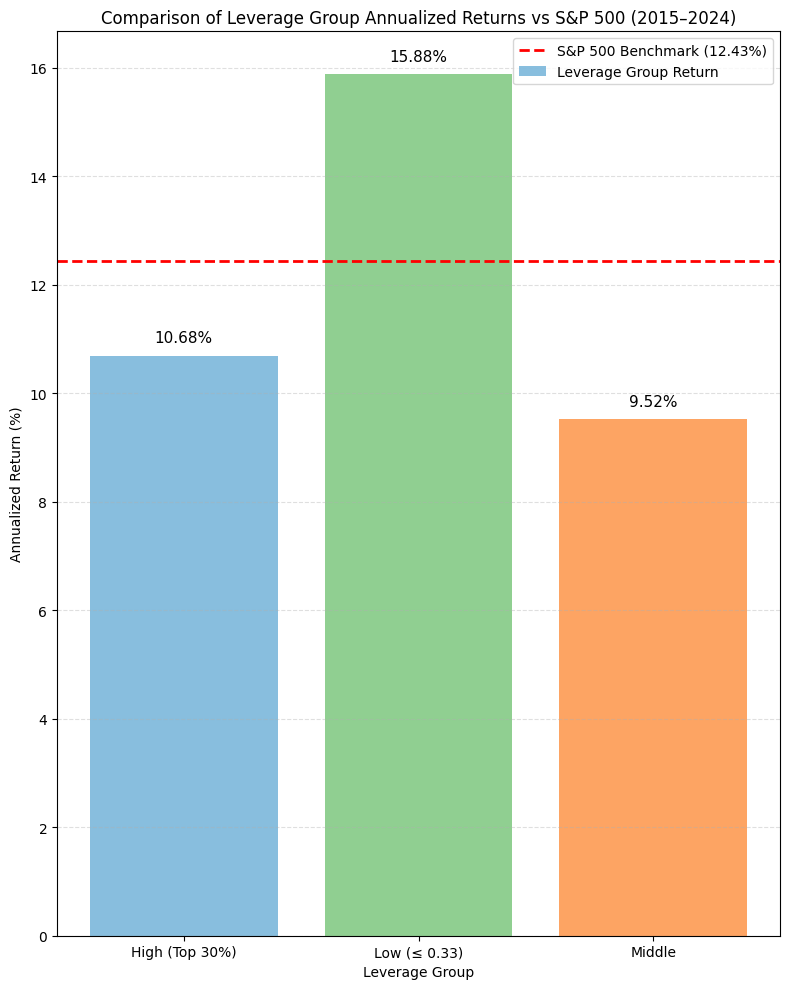

In [ ]:
groups = summary_df["leverage_group"].tolist()
returns = summary_df["ann_return_mean"].tolist()
benchmark = sp_ann_return  # S&P 500 benchmark value

plt.figure(figsize=(8,10))

# Plot the leverage group returns as bars
bars = plt.bar(groups, [r*100 for r in returns], color=['#6baed6', '#74c476', '#fd8d3c'], alpha=0.8, label="Leverage Group Return")

# Add a horizontal line for the S&P 500 benchmark
plt.axhline(benchmark*100, color='red', linestyle='--', linewidth=2, label=f"S&P 500 Benchmark ({benchmark*100:.2f}%)")

# Add labels and title
plt.title("Comparison of Leverage Group Annualized Returns vs S&P 500 (2015–2024)", fontsize=12)
plt.ylabel("Annualized Return (%)")
plt.xlabel("Leverage Group")

# Add gridlines for readability
plt.grid(axis="y", linestyle="--", alpha=0.4)

# Add numeric value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.2, f"{height:.2f}%", ha='center', va='bottom', fontsize=11)

# Add legend
plt.legend()

# Adjust layout and display the chart
plt.tight_layout()
plt.show()

# **Question 2: Is there a relationship between a company’s cash reserves and its market volatility?**

This section prepares and cleans the dataset to explore whether a company’s cash reserves are related to its market volatility. The code first loads Bloomberg’s SPX dataset and automatically identifies the relevant columns for volatility and cash ratio using keyword searches, ensuring flexibility across slightly different dataset formats. It then standardizes column names, retains only necessary variables (ticker, name, volatility, and cash ratio), and removes missing or invalid values. Finally, it exports the cleaned data into a dedicated folder (outputs_rq2) for subsequent analysis, establishing a reliable foundation to statistically test the relationship between liquidity strength and volatility levels.

In [ ]:
OUT_DIR = Path("outputs_rq2")
OUT_DIR.mkdir(parents=True, exist_ok=True)

DATA_BLOOM = "SPX Dataset Copy.xlsx"
COMP_INFO = 0

df_raw = pd.read_excel(DATA_BLOOM, sheet_name=COMP_INFO)
df_raw.columns = [str(c).strip() for c in df_raw.columns]

# Detect volatility and cash ratio columns
VOL_KEYS  = ["5y m volat"]
CASH_KEYS = ["cash", "ratio", "2015"]

def find_col(cols, keys):
    for c in cols:
        cl = c.lower()
        if all(k in cl for k in keys):
            return c
    return None

VOL_COL  = find_col(df_raw.columns, VOL_KEYS)
CASH_COL = find_col(df_raw.columns, CASH_KEYS)

print("Volatility column detected:", VOL_COL)
print("Cash ratio column detected:", CASH_COL)

df2 = df_raw.copy()

df2 = df2.rename(columns={
    VOL_COL:  "vol_5y_monthly",
    CASH_COL: "cash_ratio_1519"
})

# Keep only relevant columns
keep = [c for c in ["Ticker", "Name", "vol_5y_monthly", "cash_ratio_1519"] if c in df2.columns]
df2 = df2[keep].copy()

# Drop missing essential values
df2 = df2.dropna(subset=["vol_5y_monthly", "cash_ratio_1519"]).copy()

# Remove invalid / negative values
df2 = df2[(df2["vol_5y_monthly"] > 0) & (df2["cash_ratio_1519"] >= 0)].copy()

print("Rows after cleaning:", len(df2))
df2.to_csv(OUT_DIR / "rq2_clean_base.csv", index=False)
df2.head()



Volatility column detected: 5Y M VOLAT
Cash ratio column detected: 2015-2019 AVG CASH RATIO
Rows after cleaning: 423


,Ticker,Name,vol_5y_monthly,cash_ratio_1519
0,A UN Equity,Agilent Technologies Inc,0.278020,1.835624
1,AAPL UW Equity,Apple Inc,0.248334,0.724998
2,ABBV UN Equity,AbbVie Inc,0.220140,1.009187
3,ABNB UW Equity,Airbnb Inc,0.387359,0.739266
4,ABT UN Equity,Abbott Laboratories,0.199944,1.079734


This section calculates how strongly cash reserves are related to market volatility using both linear (Pearson) and rank-based (Spearman) correlation tests. The positive and statistically significant results suggest a modest relationship: firms with greater cash ratios tend to experience slightly higher volatility over the measured period, indicating that higher liquidity does not necessarily correspond with greater market stability.

In [ ]:
pearson_r, pearson_p = stats.pearsonr(df2["cash_ratio_1519"], df2["vol_5y_monthly"])
spearman_rho, spearman_p = stats.spearmanr(df2["cash_ratio_1519"], df2["vol_5y_monthly"])

print("\n=== Cash Reserves vs Volatility ===")
print(f"Pearson r  = {pearson_r:.4f}, p = {pearson_p:.6f}")
print(f"Spearman ρ = {spearman_rho:.4f}, p = {spearman_p:.6f}")



=== Cash Reserves vs Volatility ===
Pearson r  = 0.2915, p = 0.000000
Spearman ρ = 0.3262, p = 0.000000


The following section examines whether companies with higher cash reserves experience different levels of market volatility compared to those with lower reserves. By splitting firms at the median cash ratio, the analysis compares the average volatility between high-cash and low-cash groups. The results show that firms with higher cash ratios exhibit notably greater volatility (31.6% vs. 27.2%), and this difference is statistically significant with a moderate effect size (Cohen’s d = 0.47). This finding suggests that stronger cash positions do not necessarily translate to lower market risk — in fact, companies with more liquidity may face greater price fluctuations, potentially due to market expectations or differing investment behaviors.

In [ ]:
median_cash = df2["cash_ratio_1519"].median()
df2["cash_group"] = np.where(df2["cash_ratio_1519"] >= median_cash,
                             "High Cash (≥ median)",
                             "Low Cash (< median)")

low_vol  = df2.loc[df2["cash_group"]=="Low Cash (< median)",  "vol_5y_monthly"]
high_vol = df2.loc[df2["cash_group"]=="High Cash (≥ median)", "vol_5y_monthly"]

tstat, pval = stats.ttest_ind(high_vol, low_vol, equal_var=False)

def cohens_d(a, b):
    a, b = pd.Series(a), pd.Series(b)
    sp = np.sqrt(((a.var(ddof=1)*(len(a)-1)) + (b.var(ddof=1)*(len(b)-1))) / (len(a)+len(b)-2))
    return (a.mean() - b.mean()) / sp

d = cohens_d(high_vol, low_vol)

print("\n=== High vs Low Cash Volatility ===")
print(f"Low Cash  mean={low_vol.mean():.4%}")
print(f"High Cash mean={high_vol.mean():.4%}")
print(f"t-stat={tstat:.4f}, p-value={pval:.6f}, Cohen's d={d:.3f}")



=== High vs Low Cash Volatility ===
Low Cash  mean=27.2364%
High Cash mean=31.5988%
t-stat=4.8756, p-value=0.000002, Cohen's d=0.474


This code creates a scatter plot illustrating how companies’ cash ratios relate to their market volatility. Each point represents an individual firm, while the red regression line shows the overall trend. The upward slope of the line indicates that firms with higher cash reserves generally exhibit greater volatility, visually supporting the earlier statistical findings of a modest positive relationship between liquidity and market fluctuations.

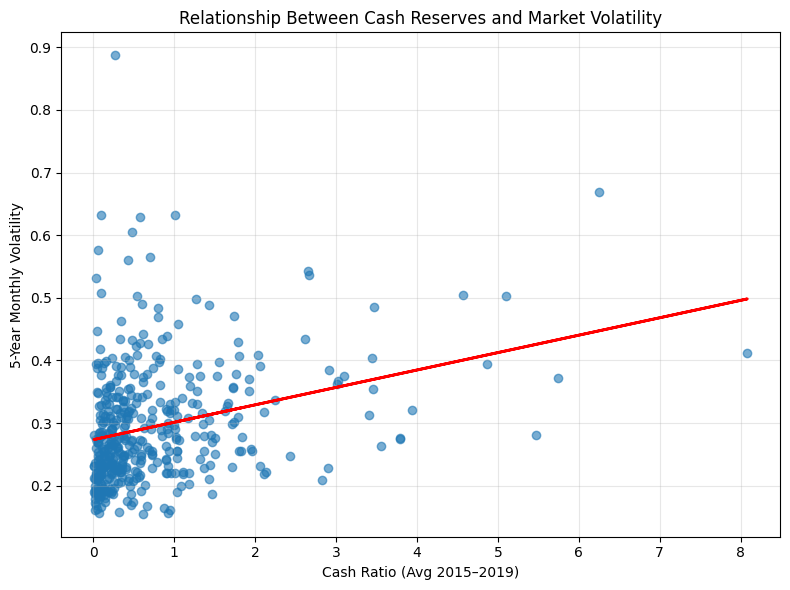

In [ ]:
plt.figure(figsize=(8,6))
x = df2["cash_ratio_1519"].values
y = df2["vol_5y_monthly"].values

b1, b0 = np.polyfit(x, y, 1)
plt.scatter(x, y, alpha=0.6)
plt.plot(x, b1*x + b0, color="red", linewidth=2)

plt.xlabel("Cash Ratio (Avg 2015–2019)")
plt.ylabel("5-Year Monthly Volatility")
plt.title("Relationship Between Cash Reserves and Market Volatility")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(OUT_DIR / "rq2_scatter_cash_vs_vol.png", dpi=200)
plt.show()


This code calculates and visualizes the average volatility of companies grouped by their cash reserves. Using 95% confidence intervals, the resulting bar chart highlights how volatility differs between high- and low-cash firms. The inclusion of error bars provides a clear visual of statistical uncertainty, showing that high-cash firms consistently exhibit greater volatility on average, reinforcing the earlier statistical findings.

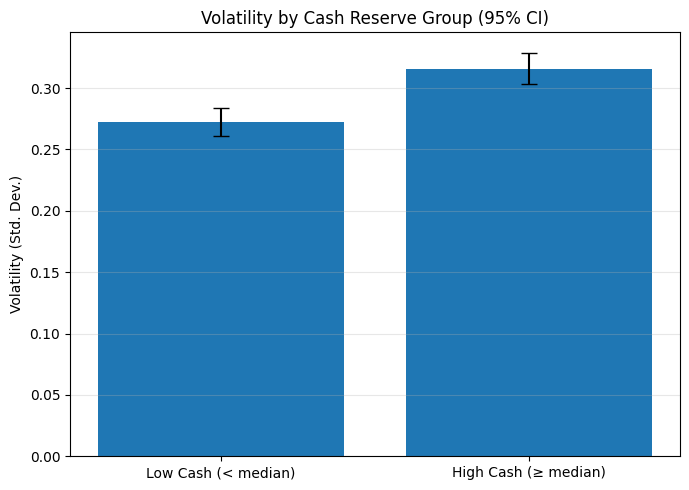

In [ ]:
def ci_mean(series):
    m = series.mean()
    se = series.std(ddof=1)/np.sqrt(len(series))
    return m, 1.96*se

groups = ["Low Cash (< median)", "High Cash (≥ median)"]
means, errs = [], []

for g in groups:
    m, hw = ci_mean(df2.loc[df2["cash_group"]==g, "vol_5y_monthly"])
    means.append(m); errs.append(hw)

plt.figure(figsize=(7,5))
plt.bar(groups, means, yerr=errs, capsize=6)
plt.ylabel("Volatility (Std. Dev.)")
plt.title("Volatility by Cash Reserve Group (95% CI)")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig(OUT_DIR / "rq2_bar_cash_groups.png", dpi=200)
plt.show()


# **Questions 3: Does maintaining a low-debt structure correlate with higher ESG ratings or community investment?**

This setup prepares the data for analyzing whether firms with lower debt ratios demonstrate stronger ESG performance or higher community investment. By organizing outputs, standardizing column names, and creating a clean copy of the dataset, the code ensures a reliable foundation for the statistical analysis and visualizations that follow.

In [ ]:

OUT_DIR = Path("outputs_rq3")
OUT_DIR.mkdir(parents=True, exist_ok=True)


df3_raw = pd.read_excel(EXCEL_PATH, sheet_name=COMP_INFO)
df3_raw.columns = [str(c).strip() for c in df3_raw.columns]  # standardize names
df3 = df3_raw.copy()


This section refines the dataset for analysis by renaming columns for clarity, keeping only essential financial and ESG data, and removing missing or invalid entries. The result is a clean, reliable dataset ready to explore whether firms with lower debt ratios tend to have stronger ESG performance.

In [ ]:
df3 = df3.rename(columns={
    "2015-2019 AVG D/E RATIO": "de_avg_1519",
    "ESG Scores": "esg_score"
})

df3 = df3[["Ticker", "Name", "de_avg_1519", "esg_score"]].copy()
df3 = df3.dropna(subset=["de_avg_1519", "esg_score"])
df3 = df3[df3["de_avg_1519"] >= 0]  # remove any negative/invalid D/E
print("Rows after cleaning:", len(df3))


Rows after cleaning: 488


In [ ]:
LOW_DEBT_THRESHOLD = 0.33

# Low debt group
df3["low_debt"] = np.where(df3["de_avg_1519"] <= LOW_DEBT_THRESHOLD, 1, 0)

# High debt group based on top 30%
high_cut = df3["de_avg_1519"].quantile(0.70)  # upper 30%
df3["high_debt"] = np.where(df3["de_avg_1519"] >= high_cut, 1, 0)

# Single label column
def assign_group(row):
    if row["low_debt"] == 1:
        return "Low Debt (≤ 0.33)"
    elif row["high_debt"] == 1:
        return "High Debt (Top 30%)"
    else:
        return "Middle"

df3["debt_group"] = df3.apply(assign_group, axis=1)

df3.to_csv(OUT_DIR / "rq3_with_groups.csv", index=False)
df3["debt_group"].value_counts()


,count
debt_group,
Middle,252
High Debt (Top 30%),147
Low Debt (≤ 0.33),89


This code classifies companies into three debt-based groups using clear ratio thresholds. By labeling each firm according to its debt level, the dataset becomes ready for comparisons of ESG scores and community investment across different leverage categories.

In [ ]:
low = df3.loc[df3["debt_group"]=="Low Debt (≤ 0.33)", "esg_score"]
high = df3.loc[df3["debt_group"]=="High Debt (Top 30%)", "esg_score"]

tstat, pval = stats.ttest_ind(low, high, equal_var=False)

def cohens_d(a, b):
    a, b = pd.Series(a), pd.Series(b)
    sp = np.sqrt(((a.var(ddof=1)*(len(a)-1)) + (b.var(ddof=1)*(len(b)-1))) / (len(a)+len(b)-2))
    return (a.mean() - b.mean()) / sp

d = cohens_d(low, high)

print("\n=== ESG Score Comparison: Low Debt vs High Debt ===")
print(f"Low Debt  mean = {low.mean():.3f} (n={len(low)})")
print(f"High Debt mean = {high.mean():.3f} (n={len(high)})")
print(f"t-statistic = {tstat:.4f}, p-value = {pval:.6f}, Cohen's d = {d:.3f}")



=== ESG Score Comparison: Low Debt vs High Debt ===
Low Debt  mean = 4.350 (n=89)
High Debt mean = 5.097 (n=147)
t-statistic = -4.2110, p-value = 0.000046, Cohen's d = -0.618


This analysis compares ESG performance across companies with different debt levels. Results indicate that firms with higher debt ratios tend to have significantly higher ESG scores than low-debt firms. The difference is statistically meaningful and moderately large, suggesting that companies investing heavily (and thus carrying more debt) may also be more active in sustainability or community-focused initiatives.

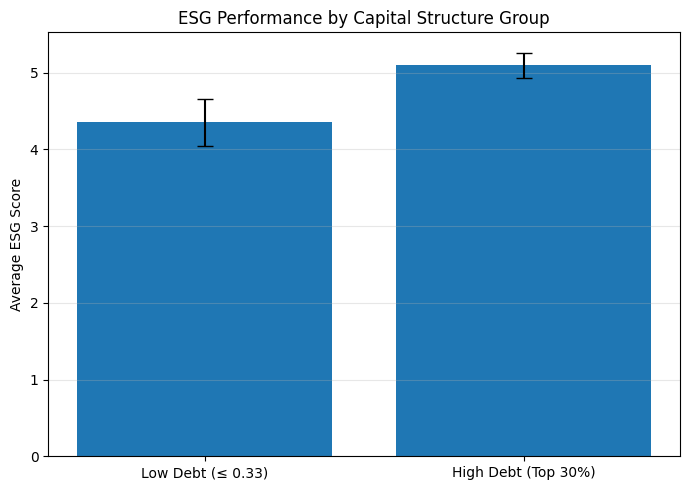

In [ ]:
def ci_mean(series):
    m = series.mean()
    se = series.std(ddof=1)/np.sqrt(len(series))
    return m, 1.96*se

groups = ["Low Debt (≤ 0.33)", "High Debt (Top 30%)"]
means, errs = [], []

for g in groups:
    m, hw = ci_mean(df3.loc[df3["debt_group"]==g, "esg_score"])
    means.append(m); errs.append(hw)

plt.figure(figsize=(7,5))
plt.bar(groups, means, yerr=errs, capsize=6)
plt.ylabel("Average ESG Score")
plt.title("ESG Performance by Capital Structure Group")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig(OUT_DIR / "rq3_esg_bar.png", dpi=200)
plt.show()


This code visualizes ESG performance across low- and high-debt companies using a bar chart with 95% confidence intervals. The plot highlights that firms in the high-debt group have higher average ESG scores than low-debt firms, and the narrow error bars suggest the difference is consistent and statistically meaningful.